In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

2022-09-01 12:51:12.657865: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-01 12:51:12.724290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 12:51:12.724325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# First BaseModel with some data from ArXiv.org (not yet the final dataset)
#### and some preprocessing

In [3]:
# Reading Data
data = pd.read_csv('../raw_data/small_dataset.csv')
data = data.drop(columns='Unnamed: 0')
data = data.rename(columns={'0': 'text'})
data.head()

,text,subtopic
0,2 2 0 2 g u A 6 2 ] E H . h p - o r t s a [ ...,Astrophysics
1,"Draft version August 29, 2022 Typeset using LA...",Astrophysics
2,Astronomy & Astrophysics manuscript no. 41891c...,Astrophysics
3,Astronomy & Astrophysics manuscript no. aa Aug...,Astrophysics
4,2 2 0 2 g u A 6 2 ] R S . h p - o r t s a [...,Astrophysics


In [4]:
# Lowercasing everything
data = data.apply(lambda x: x.astype(str).str.lower())

In [5]:
# Removing anything apart from lower case letters 
data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))

In [6]:
# Tokenizing
data['modified text'] = data['text'].apply(word_tokenize)

In [7]:
# Stopwords Removal and Removal of words consisting of single letters
stop_words = set(stopwords.words('english'))

data['modified text'] = data['modified text'].apply(lambda x: [word for word in x if not word in stop_words])
data['modified text'] = data['modified text'].apply(lambda x: [word for word in x if len(word)>1])

data['words per text'] = data['text'].apply(lambda x : len(x)) 
data['words per modified text'] = data['modified text'].apply(lambda x : len(x)) 
data

,text,subtopic,modified text,words per text,words per modified text
0,g u a e h h p o r t s a ...,astrophysics,"[mnras, preprint, august, compiled, using, mnr...",58690,4674
1,draft version august typeset using la...,astrophysics,"[draft, version, august, typeset, using, latex...",55930,5331
2,astronomy astrophysics manuscript no c...,astrophysics,"[astronomy, astrophysics, manuscript, corr, au...",46117,4103
3,astronomy astrophysics manuscript no aa aug...,astrophysics,"[astronomy, astrophysics, manuscript, aa, augu...",78395,7614
4,g u a r s h p o r t s a ...,astrophysics,"[mnras, preprint, august, compiled, using, mnr...",61921,5454
...,...,...,...,...,...
2030,g u a a f h t a m v ...,symplectic geometry,"[fusion, frame, homotopy, tightening, fusion, ...",70325,6085
2031,universidad complutense de madrid facultad de...,symplectic geometry,"[universidad, complutense, de, madrid, faculta...",79210,4816
2032,g u a g s h t a m v ...,symplectic geometry,"[barcode, pair, compact, exact, lagrangians, p...",46697,3556
2033,g u a g s h t a m v ...,symplectic geometry,"[locally, conformally, symplectic, deformation...",26625,2023


In [33]:
# Target Encoding after turning subtopics into topics
data['subtopic'].unique()

array(['astrophysics', 'condensed matter',
       'general relativity and quantum cosmology',
       'high energy physics - experiment',
       'high energy physics - lattice',
       'high energy physics - phenomenology',
       'high energy physics - theory', 'mathematical physics',
       'nonlinear sciences', 'nuclear experiment', 'nuclear theory',
       'quantum physics', 'algebraic geometry', 'algebraic topology',
       'analysis of pdes', 'category theory',
       'classical analysis and odes', 'combinatorics',
       'commutative algebra', 'complex variables',
       'differential geometry', 'dynamical systems',
       'functional analysis', 'general mathematics', 'general topology',
       'geometric topology', 'group theory', 'history and overview',
       'information theory', 'k-theory and homology', 'logic',
       'metric geometry', 'number theory', 'numerical analysis',
       'operator algebras', 'optimization and control', 'probability',
       'quantum algebra', 're

In [9]:
physics_list = ['astrophysics', 'condensed matter', 'general relativity and quantum cosmology', 'high energy physics - experiment', 
                'high energy physics - lattice', 'high energy physics - phenomenology', 'high energy physics - Tteory',
                'mathematical physics', 'nonlinear sciences', 'nuclear experiment', 'nuclear theory', 'physics', 'quantum physics']

In [10]:
# Physics as mapped with 0, Maths is mapped with 1
data['topic'] = data['subtopic'].apply(lambda x: 0 if x in physics_list else 1)

In [11]:
data['topic'].value_counts()

1    1196
0     839
Name: topic, dtype: int64

In [12]:
data[['modified text', 'topic']]

,modified text,topic
0,"[mnras, preprint, august, compiled, using, mnr...",0
1,"[draft, version, august, typeset, using, latex...",0
2,"[astronomy, astrophysics, manuscript, corr, au...",0
3,"[astronomy, astrophysics, manuscript, aa, augu...",0
4,"[mnras, preprint, august, compiled, using, mnr...",0
...,...,...
2030,"[fusion, frame, homotopy, tightening, fusion, ...",1
2031,"[universidad, complutense, de, madrid, faculta...",1
2032,"[barcode, pair, compact, exact, lagrangians, p...",1
2033,"[locally, conformally, symplectic, deformation...",1


### If we wanted to feed our paper fulltexts directly into RNNs:

In [13]:
# Tokenize according to goal (feed into RNN)
tk = Tokenizer()
tk.fit_on_texts(data['modified text'])
vocab_size = len(tk.word_index)
print(f'There are {vocab_size} different words in our corpus')

X_token = tk.texts_to_sequences(data['modified text'])

There are 143055 different words in our corpus


In [14]:
# Add Padding
X_pad = pad_sequences(X_token, dtype='float32', padding='post', value=0)

In [15]:
longest_list_in_data = data['modified text'].map(len).max()
print(f'The shape of the padding X_pad.shape {X_pad.shape} matches the length of the longest list in our dataframe ({longest_list_in_data}), so it seems the padding went alright.')

The shape of the padding X_pad.shape (2035, 46773) matches the length of the longest list in our dataframe (46773), so it seems the padding went alright.


### But here we will embed our sentences into an already pretrained word embedding (so we actually don't need the tokenization and the padding as provided by tensorflow)

In [17]:
# Let's go back to our original data
data[['modified text', 'topic', 'words per modified text']]

,modified text,topic,words per modified text
0,"[mnras, preprint, august, compiled, using, mnr...",0,4674
1,"[draft, version, august, typeset, using, latex...",0,5331
2,"[astronomy, astrophysics, manuscript, corr, au...",0,4103
3,"[astronomy, astrophysics, manuscript, aa, augu...",0,7614
4,"[mnras, preprint, august, compiled, using, mnr...",0,5454
...,...,...,...
2030,"[fusion, frame, homotopy, tightening, fusion, ...",1,6085
2031,"[universidad, complutense, de, madrid, faculta...",1,4816
2032,"[barcode, pair, compact, exact, lagrangians, p...",1,3556
2033,"[locally, conformally, symplectic, deformation...",1,2023


## Neural network architechture with three components:

    1. An embedding layer that inherits word embedding from word2vec.
    2. A hidden layer of one or more layers, which introduces non-linearity to the embeddings.
    3. A softmax function that produces probability distribution over all the words in the vocabulary. 


### Embedding our papers into a word2vec representation

In [18]:
# Downloading a pre-trained model, based on a 50 space vector representation from wikidata
word2vec_transfer = api.load("glove-wiki-gigaword-50")
word2vec_transfer['saturn'].shape # checking the shape of the vectors: (50, )
print('Vocabulary size', len(word2vec_transfer))

Vocabulary size 400000


In [19]:
# Function to convert an article (list of words) into a matrix representing the words in the embedding space
def embed_article(word2vec_space, article):
    embedded_sentence = []
    for word in article:
        if word in word2vec_space:
            embedded_sentence.append(word2vec_space[word])
        
    return np.array(embedded_sentence)

In [20]:
test_sentence_embedded = embed_article(word2vec_transfer, data['modified text'][0])
test_sentence_embedded.shape # some words have been skipped, because certainly they weren't contained in the glove-wiki-gigaword-50 representation


(4468, 50)

In [21]:
# Function that converts a list of sentences into a list of matrices
def embedding(word2vec_space, series_of_articles):
    embed = []
    
    for ele in series_of_articles:
        embedded_article = embed_article(word2vec_space, ele)
        embed.append(embedded_article)
        
    return embed

In [22]:
#embedding(data['modified text'][0])

In [23]:
# Adding a column with embedded words into data frame
series_embedded = embedding(word2vec_transfer, data['modified text'])
data['embedded text'] = series_embedded

In [24]:
# Checking the data in terms of the padding
data[['modified text', 'topic', 'words per modified text', 'embedded text']]\
    .sort_values(by=['words per modified text'], ascending=False)

,modified text,topic,words per modified text,embedded text
27,"[chasing, tails, active, asteroid, centaur, qu...",0,46773,"[[0.15951, -0.5635, 0.72258, -0.47059, 0.50038..."
111,"[laser, plasma, research, institute, shahid, b...",0,46303,"[[0.23938, 0.26055, 1.3418, 0.13929, -0.71689,..."
1531,"[orthogonal, time, frequency, space, otfs, mod...",1,36256,"[[1.9414, -0.11206, 0.3262, 0.73552, 2.1636, 0..."
1054,"[attractors, sergey, zelik, abstract, survey, ...",1,31767,"[[0.89704, -1.0991, -0.51563, 1.425, -0.010864..."
1339,"[attractors, sergey, zelik, abstract, survey, ...",1,31767,"[[0.89704, -1.0991, -0.51563, 1.425, -0.010864..."
...,...,...,...,...
1569,"[sdbert, sparsedistilbert, faster, smaller, be...",1,493,"[[0.10351, -0.83927, 1.446, -0.51137, -0.32939..."
940,"[proof, brill, noether, method, scratch, elena...",1,462,"[[0.37481, 0.57314, 0.48017, -0.056679, 0.7047..."
1774,"[short, simple, proof, closedness, convex, con...",1,229,"[[0.08226, 0.52026, -0.13314, -0.78449, -0.236..."
1964,"[short, simple, proof, closedness, convex, con...",1,229,"[[0.08226, 0.52026, -0.13314, -0.78449, -0.236..."


<AxesSubplot:>

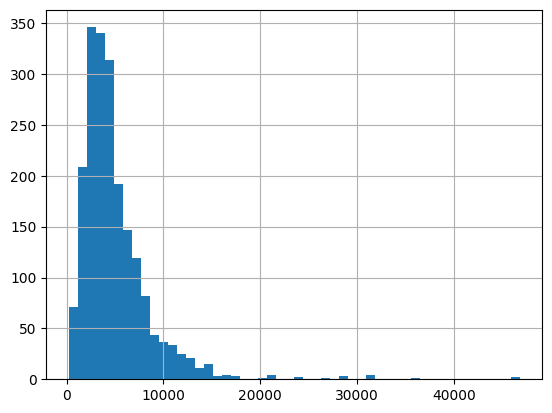

In [25]:
data['words per modified text'].hist(bins = 50)

#### It seems reasonable to exclude all the vectors after the 15,000th vector. For ensuring that this notebook is continuing to execute, I had to cut vectors after the 10,000 vector though. If the model trains too slowly, we can exclude more.

In [26]:
# Padding all the embedded words
X_pad = pad_sequences(series_embedded, dtype='float32', padding='post', value=0, maxlen=100)

In [27]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, data['topic'], test_size=0.3)

### RNN Model on already pretrained vectors

In [28]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [29]:
model = init_model()

2022-09-01 12:52:56.832839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-01 12:52:56.832859: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-01 12:52:56.832873: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Future): /proc/driver/nvidia/version does not exist
2022-09-01 12:52:56.833479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 100, 50)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                5680      
                                                                 
 dense (Dense)               (None, 15)                315       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 6,011
Trainable params: 6,011
Non-trainable params: 0
_________________________________________________________________


In [30]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
          			batch_size = 32,
         			epochs=100,
          			validation_split=0.3,
          			callbacks=[es])

Epoch 1/100
32/32 [==============================] - 5s 58ms/step - loss: 0.6143 - accuracy: 0.6727 - val_loss: 0.5605 - val_accuracy: 0.7056
Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 0.5184 - accuracy: 0.7641 - val_loss: 0.4714 - val_accuracy: 0.7921
Epoch 3/100
32/32 [==============================] - 1s 29ms/step - loss: 0.4563 - accuracy: 0.8072 - val_loss: 0.4210 - val_accuracy: 0.8084
Epoch 4/100
32/32 [==============================] - 1s 29ms/step - loss: 0.4205 - accuracy: 0.8153 - val_loss: 0.4224 - val_accuracy: 0.8201
Epoch 5/100
32/32 [==============================] - 1s 28ms/step - loss: 0.4020 - accuracy: 0.8173 - val_loss: 0.4791 - val_accuracy: 0.7827
Epoch 6/100
32/32 [==============================] - 1s 29ms/step - loss: 0.3892 - accuracy: 0.8343 - val_loss: 0.4021 - val_accuracy: 0.8435
Epoch 7/100
32/32 [==============================] - 1s 30ms/step - loss: 0.3665 - accuracy: 0.8434 - val_loss: 0.4300 - val_accuracy: 0.8061
Epoch 

In [31]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 83.797%


#### I also ran this model in Google Colab with a padding with maxlen=5000, but this only got to 81.997% accuracy.